В данной реализации я не прибегал к скрупулезной очистке данных и подробному анализу. Это учебный датасет, в котором не хватает к примеру координат для парсинга расстояния до ближайших линий общественного трансопорта, объектов инфраструктуры и т.д. Цель - попытаться извлечь максимум пользы из уже имеющихся данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
import catboost
from catboost import Pool
import seaborn as sns


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams.update({'font.size' : 10})
sns.set(rc={"figure.figsize": (6, 4)})

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train.drop('Id', axis = 1)
test_wId = test
test = test.drop('Id', axis= 1)

#### Выведем новый признак на основе DistrictId

In [3]:
price_dist_median = train.groupby('DistrictId')[['Price']].median().reset_index()

train = pd.merge(train,price_dist_median, how = 'left', on = 'DistrictId')
train.rename(columns = {'Price_x' : 'Price', 'Price_y' : 'Dist_Price'}, inplace = True)

test = pd.merge(test,price_dist_median, how = 'left', on = 'DistrictId')
test.rename(columns = {'Price' : 'Dist_Price'}, inplace = True)
# В train есть не все районы, которые находятся в test, поэтому при мердже появилось несколько пропусков
# Их не много, заполним нулевой модой
test['Dist_Price'] = test['Dist_Price'].fillna(test['Dist_Price'].mode()[0])
test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Dist_Price
0,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B,151557.904767
1,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,195610.960042
2,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,526438.458919
3,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B,196429.659238
4,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,146171.433190


#### Удалим Healthcare_1

In [4]:
train.drop(columns='Healthcare_1', inplace=True)
test.drop(columns='Healthcare_1', inplace=True)

#### Square & Lifesquare & KitchenSquare

In [5]:
# 0.8 - произвольный коэффициент для соразмерности прощадей
train.LifeSquare = train.LifeSquare.fillna(train.LifeSquare.mean())
train.loc[train['Square'] > 600, 'Square'] = train['Square'].median()
train.loc[train['Square'] < train['LifeSquare'], 'LifeSquare'] = train.Square * 0.8
train.loc[(train['KitchenSquare'] == 0) | (train['KitchenSquare'] > train['LifeSquare']), 'KitchenSquare'] = train.Square - train.LifeSquare

test.LifeSquare = test.LifeSquare.fillna(test.LifeSquare.mean())
test.loc[test['Square'] < test['LifeSquare'], 'LifeSquare'] = test.Square * 0.8
test.loc[(test['KitchenSquare'] == 0) | (test['KitchenSquare'] > test['LifeSquare']), 'KitchenSquare'] = test.Square - test.LifeSquare

#### Rooms

In [6]:
train.loc[(train['Square'] < 100), 'Rooms'] = 1
train.loc[(train['Square'] >= 100), 'Rooms'] = 2

test.loc[(test['Square'] < 100), 'Rooms'] = 1
test.loc[(test['Square'] >= 100), 'Rooms'] = 2

#### HouseYear

In [7]:
train.loc[train['HouseYear'] > 2021, 'HouseYear'] = train.HouseYear.median()
test.loc[test['HouseYear'] > 2021, 'HouseYear'] = test.HouseYear.median()

#### Room / S

In [8]:
train['S / Room'] = (train['Square']/train['Rooms']).astype('float64')
test['S / Room'] = (test['Square']/test['Rooms']).astype('float64')

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,209.000000
Rooms,10000.0,1.026000,0.159143,1.000000,1.000000,1.000000,1.000000,2.000000
Square,10000.0,56.201701,19.472731,1.136859,41.774881,52.513040,65.890819,409.425181
LifeSquare,10000.0,35.577602,15.060492,0.370619,25.165748,36.458969,40.341931,327.540145
KitchenSquare,10000.0,7.174520,7.428518,0.021395,1.000000,7.000000,9.000000,132.817227
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,42.000000
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,117.000000
HouseYear,10000.0,1984.863800,18.409979,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,0.521867
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,74.000000


In [10]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.026200,0.159746,1.000000,1.000000,1.000000,1.000000,2.000000
Square,5000.0,56.449500,19.092787,1.378543,41.906231,52.921340,66.285129,223.453689
LifeSquare,5000.0,35.366952,14.313447,0.333490,25.331777,36.158810,40.669771,136.921090
KitchenSquare,5000.0,7.115745,7.132827,0.058925,3.000000,6.000000,9.000000,122.041783
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,78.000000
HouseFloor,5000.0,12.601000,6.789213,0.000000,9.000000,12.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867
Social_1,5000.0,24.933800,17.532202,0.000000,6.000000,25.000000,36.000000,74.000000


### PCA

In [11]:
important = ['Square','Dist_Price','S / Room']
n = 2
names = ['pca_' + str(i+1) for i in range(n)]

In [12]:
pca = PCA(n_components=n)

train_components = pca.fit_transform(train[important])
train_components = pd.DataFrame(data=train_components, columns=names)
train = pd.concat([train, train_components], axis=1)
train_components.head()
train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Dist_Price,S / Room,pca_1,pca_2
0,35,1.0,47.981561,29.442751,6.000000,7,9.0,1969.0,0.089040,B,...,7976,5,0,11,B,184966.930730,203602.408898,47.981561,1686.195066,-10.629523
1,41,1.0,65.683640,40.049543,8.000000,7,9.0,1978.0,0.000070,B,...,10309,1,1,16,B,300009.450063,210694.850106,65.683640,8778.637042,14.020018
2,53,1.0,44.947953,29.197612,15.750341,8,12.0,1968.0,0.049637,B,...,7759,0,1,3,B,220925.908524,245978.794474,44.947953,44062.580489,-16.210408
3,58,1.0,53.352981,52.731512,9.000000,8,17.0,1977.0,0.437885,B,...,5735,3,0,5,B,175616.227217,151557.904767,53.352981,-50358.308806,-1.463266
4,99,1.0,39.649192,23.776169,7.000000,11,12.0,1976.0,0.012339,B,...,5776,1,2,4,B,150226.531644,178829.166450,39.649192,-23087.047733,-21.564956


In [13]:
pca = PCA(n_components=n)

test_components = pca.fit_transform(test[important])
test_components = pd.DataFrame(data=test_components, columns=names)
test = pd.concat([test, test_components], axis=1)
test_components.head()
test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Dist_Price,S / Room,pca_1,pca_2
0,58,1.0,49.882643,33.432782,6.000000,6,14.0,1972.0,0.310199,B,...,11,2748,1,0,0,B,151557.904767,49.882643,-50523.812745,-7.496229
1,74,1.0,69.263183,36.158810,1.000000,6,1.0,1977.0,0.075779,B,...,6,1437,3,0,2,B,195610.960042,69.263183,-6470.757062,19.098203
2,190,1.0,13.597819,10.878255,2.719564,2,5.0,1909.0,0.000000,B,...,30,7538,87,5,5,B,526438.458919,13.597819,324356.740589,-64.254932
3,47,1.0,73.046609,51.940842,9.000000,22,22.0,2007.0,0.101872,B,...,23,4583,3,3,3,B,196429.659238,73.046609,-5652.057785,24.408455
4,27,1.0,47.527111,43.387569,1.000000,17,17.0,2017.0,0.072158,B,...,2,629,1,0,0,A,146171.433190,47.527111,-55910.284372,-10.728055


### Dummies

In [14]:
X = pd.get_dummies(train)
X.drop("Price", axis=1, inplace=True)
y = train['Price']

In [15]:
X_test = pd.get_dummies(test)

### Нормализуем и разобьем на train test

In [16]:
scaler = StandardScaler()

In [17]:
features = X.select_dtypes(include = ['float64','int64']).columns.to_list()
X[features] = scaler.fit_transform(X[features])
X_test[features] = scaler.transform(X_test[features])

In [18]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.3, random_state = 42)

Общая модель может обучаться дольше чем обычно, у меня весь ноутбук отрабатывает не более 2х минут.
Данная комбинация дает +0.02 относительно каждой по одиночке

In [19]:
mod_1 = GradientBoostingRegressor(n_estimators=400, max_depth=5, min_samples_split=2,
                                           learning_rate=0.1, loss='ls', random_state=42)

mod_2 = RandomForestRegressor(n_estimators=1442, max_depth=5, random_state=42, max_features=10)

mod_3 = catboost.CatBoostRegressor(learning_rate=0.1,depth=5,l2_leaf_reg=0.01)

model = VotingRegressor([('model_1', mod_1), ('model_2', mod_2),('model_3', mod_3)])

Графики голосования.

Долго, но красиво)

In [20]:
xt = X_train[:20]

mod_1.fit(X_train, y_train)
mod_2.fit(X_train, y_train)
mod_3.fit(X_train, y_train)
model.fit(X_train, y_train)

pred1 = mod_1.predict(xt)
pred2 = mod_2.predict(xt)
pred3 = mod_3.predict(xt)
pred4 = model.predict(xt)

0:	learn: 87240.0338737	total: 142ms	remaining: 2m 21s
1:	learn: 82416.8178573	total: 144ms	remaining: 1m 11s
2:	learn: 78048.1735162	total: 146ms	remaining: 48.4s
3:	learn: 74388.4214404	total: 148ms	remaining: 36.9s
4:	learn: 71181.5293922	total: 150ms	remaining: 29.8s
5:	learn: 68321.6472092	total: 152ms	remaining: 25.1s
6:	learn: 65982.3121180	total: 153ms	remaining: 21.8s
7:	learn: 63770.6509276	total: 157ms	remaining: 19.4s
8:	learn: 61880.9434898	total: 159ms	remaining: 17.5s
9:	learn: 60123.2985819	total: 161ms	remaining: 15.9s
10:	learn: 58625.1688396	total: 163ms	remaining: 14.6s
11:	learn: 57420.8818077	total: 164ms	remaining: 13.5s
12:	learn: 56408.8544712	total: 166ms	remaining: 12.6s
13:	learn: 55575.9365890	total: 169ms	remaining: 11.9s
14:	learn: 54798.8788967	total: 173ms	remaining: 11.3s
15:	learn: 54045.9352487	total: 175ms	remaining: 10.8s
16:	learn: 53505.5137248	total: 178ms	remaining: 10.3s
17:	learn: 52834.7906356	total: 181ms	remaining: 9.85s
18:	learn: 52344.6

160:	learn: 38870.2640767	total: 458ms	remaining: 2.39s
161:	learn: 38831.3605012	total: 460ms	remaining: 2.38s
162:	learn: 38783.8756908	total: 463ms	remaining: 2.38s
163:	learn: 38744.5252229	total: 464ms	remaining: 2.37s
164:	learn: 38686.0176391	total: 466ms	remaining: 2.36s
165:	learn: 38648.4653506	total: 468ms	remaining: 2.35s
166:	learn: 38605.5357927	total: 470ms	remaining: 2.34s
167:	learn: 38568.7227908	total: 472ms	remaining: 2.34s
168:	learn: 38530.8401128	total: 474ms	remaining: 2.33s
169:	learn: 38478.0970381	total: 476ms	remaining: 2.33s
170:	learn: 38443.0391688	total: 478ms	remaining: 2.32s
171:	learn: 38400.0309568	total: 480ms	remaining: 2.31s
172:	learn: 38356.1509947	total: 482ms	remaining: 2.3s
173:	learn: 38320.2151535	total: 484ms	remaining: 2.3s
174:	learn: 38275.9677071	total: 486ms	remaining: 2.29s
175:	learn: 38226.3995517	total: 487ms	remaining: 2.28s
176:	learn: 38166.9218166	total: 490ms	remaining: 2.28s
177:	learn: 38102.7040115	total: 491ms	remaining: 

365:	learn: 32173.3155953	total: 939ms	remaining: 1.63s
366:	learn: 32154.1886918	total: 941ms	remaining: 1.62s
367:	learn: 32136.5388869	total: 944ms	remaining: 1.62s
368:	learn: 32122.6424328	total: 946ms	remaining: 1.62s
369:	learn: 32085.6722242	total: 949ms	remaining: 1.62s
370:	learn: 32070.8089171	total: 952ms	remaining: 1.61s
371:	learn: 32033.7870303	total: 958ms	remaining: 1.62s
372:	learn: 32014.1697640	total: 960ms	remaining: 1.61s
373:	learn: 31986.1946653	total: 962ms	remaining: 1.61s
374:	learn: 31967.0753324	total: 965ms	remaining: 1.61s
375:	learn: 31940.6876000	total: 969ms	remaining: 1.61s
376:	learn: 31906.3809508	total: 971ms	remaining: 1.6s
377:	learn: 31875.8860336	total: 974ms	remaining: 1.6s
378:	learn: 31852.0847965	total: 977ms	remaining: 1.6s
379:	learn: 31824.4255925	total: 981ms	remaining: 1.6s
380:	learn: 31794.3234933	total: 984ms	remaining: 1.6s
381:	learn: 31759.0173949	total: 988ms	remaining: 1.6s
382:	learn: 31730.3004544	total: 993ms	remaining: 1.6s

552:	learn: 28266.8015380	total: 1.4s	remaining: 1.14s
553:	learn: 28255.5513615	total: 1.41s	remaining: 1.13s
554:	learn: 28239.2625809	total: 1.41s	remaining: 1.13s
555:	learn: 28229.8952482	total: 1.41s	remaining: 1.13s
556:	learn: 28221.3146954	total: 1.41s	remaining: 1.12s
557:	learn: 28210.4872727	total: 1.41s	remaining: 1.12s
558:	learn: 28203.6497642	total: 1.42s	remaining: 1.12s
559:	learn: 28183.8354033	total: 1.42s	remaining: 1.11s
560:	learn: 28161.4007532	total: 1.42s	remaining: 1.11s
561:	learn: 28139.4326826	total: 1.42s	remaining: 1.11s
562:	learn: 28123.5885884	total: 1.42s	remaining: 1.1s
563:	learn: 28071.0336381	total: 1.42s	remaining: 1.1s
564:	learn: 28047.7976604	total: 1.43s	remaining: 1.1s
565:	learn: 28040.0380748	total: 1.43s	remaining: 1.1s
566:	learn: 28015.1715897	total: 1.43s	remaining: 1.09s
567:	learn: 28005.6681379	total: 1.43s	remaining: 1.09s
568:	learn: 27995.7349863	total: 1.43s	remaining: 1.09s
569:	learn: 27971.6785528	total: 1.44s	remaining: 1.0

704:	learn: 25866.8458878	total: 1.72s	remaining: 721ms
705:	learn: 25848.5497045	total: 1.73s	remaining: 718ms
706:	learn: 25831.5169232	total: 1.73s	remaining: 716ms
707:	learn: 25801.3720019	total: 1.73s	remaining: 713ms
708:	learn: 25792.4271724	total: 1.73s	remaining: 710ms
709:	learn: 25782.4389830	total: 1.73s	remaining: 708ms
710:	learn: 25764.8871855	total: 1.73s	remaining: 705ms
711:	learn: 25744.7560005	total: 1.74s	remaining: 702ms
712:	learn: 25736.7556864	total: 1.74s	remaining: 700ms
713:	learn: 25717.7686203	total: 1.74s	remaining: 697ms
714:	learn: 25699.6834321	total: 1.74s	remaining: 694ms
715:	learn: 25692.3918323	total: 1.74s	remaining: 692ms
716:	learn: 25678.1997194	total: 1.75s	remaining: 689ms
717:	learn: 25662.1649497	total: 1.75s	remaining: 687ms
718:	learn: 25650.7226145	total: 1.75s	remaining: 684ms
719:	learn: 25637.4960094	total: 1.75s	remaining: 681ms
720:	learn: 25625.1937560	total: 1.75s	remaining: 679ms
721:	learn: 25610.2684080	total: 1.76s	remaining

869:	learn: 23851.1539091	total: 2.04s	remaining: 306ms
870:	learn: 23844.2492893	total: 2.05s	remaining: 303ms
871:	learn: 23834.6230388	total: 2.05s	remaining: 301ms
872:	learn: 23826.5563299	total: 2.05s	remaining: 298ms
873:	learn: 23818.1851014	total: 2.05s	remaining: 296ms
874:	learn: 23813.6257998	total: 2.06s	remaining: 294ms
875:	learn: 23800.9606558	total: 2.06s	remaining: 291ms
876:	learn: 23795.4824888	total: 2.06s	remaining: 289ms
877:	learn: 23772.3398634	total: 2.06s	remaining: 286ms
878:	learn: 23756.3096941	total: 2.06s	remaining: 284ms
879:	learn: 23748.2799066	total: 2.06s	remaining: 281ms
880:	learn: 23740.8629277	total: 2.07s	remaining: 279ms
881:	learn: 23732.6475657	total: 2.07s	remaining: 277ms
882:	learn: 23713.8802514	total: 2.07s	remaining: 274ms
883:	learn: 23703.1539646	total: 2.07s	remaining: 272ms
884:	learn: 23694.2163681	total: 2.07s	remaining: 269ms
885:	learn: 23683.8741458	total: 2.08s	remaining: 267ms
886:	learn: 23675.5718884	total: 2.08s	remaining

67:	learn: 44433.5643525	total: 162ms	remaining: 2.23s
68:	learn: 44368.1676784	total: 165ms	remaining: 2.22s
69:	learn: 44252.1795322	total: 166ms	remaining: 2.21s
70:	learn: 44226.5429711	total: 168ms	remaining: 2.2s
71:	learn: 44149.3428639	total: 170ms	remaining: 2.19s
72:	learn: 44084.5588823	total: 172ms	remaining: 2.19s
73:	learn: 43999.3895828	total: 175ms	remaining: 2.19s
74:	learn: 43969.1242298	total: 177ms	remaining: 2.18s
75:	learn: 43916.1352317	total: 179ms	remaining: 2.17s
76:	learn: 43878.4435665	total: 181ms	remaining: 2.16s
77:	learn: 43757.0861925	total: 182ms	remaining: 2.15s
78:	learn: 43693.5786026	total: 188ms	remaining: 2.19s
79:	learn: 43665.8243184	total: 190ms	remaining: 2.18s
80:	learn: 43587.1158366	total: 192ms	remaining: 2.17s
81:	learn: 43533.1743055	total: 194ms	remaining: 2.17s
82:	learn: 43475.9945919	total: 196ms	remaining: 2.16s
83:	learn: 43393.3271069	total: 198ms	remaining: 2.15s
84:	learn: 43340.2600084	total: 200ms	remaining: 2.15s
85:	learn: 

226:	learn: 36153.6662080	total: 485ms	remaining: 1.65s
227:	learn: 36113.4309532	total: 487ms	remaining: 1.65s
228:	learn: 36079.4761880	total: 489ms	remaining: 1.65s
229:	learn: 36047.7827997	total: 491ms	remaining: 1.64s
230:	learn: 36002.6363459	total: 493ms	remaining: 1.64s
231:	learn: 35978.1156139	total: 495ms	remaining: 1.64s
232:	learn: 35949.1951478	total: 497ms	remaining: 1.64s
233:	learn: 35909.0018524	total: 499ms	remaining: 1.63s
234:	learn: 35876.7748131	total: 500ms	remaining: 1.63s
235:	learn: 35843.5288581	total: 503ms	remaining: 1.63s
236:	learn: 35805.0729571	total: 505ms	remaining: 1.62s
237:	learn: 35765.8331546	total: 507ms	remaining: 1.62s
238:	learn: 35732.4715565	total: 508ms	remaining: 1.62s
239:	learn: 35692.0337296	total: 510ms	remaining: 1.61s
240:	learn: 35658.6984288	total: 512ms	remaining: 1.61s
241:	learn: 35640.6129234	total: 514ms	remaining: 1.61s
242:	learn: 35594.4168663	total: 516ms	remaining: 1.61s
243:	learn: 35568.6852043	total: 518ms	remaining

427:	learn: 30641.1342673	total: 958ms	remaining: 1.28s
428:	learn: 30615.3023323	total: 982ms	remaining: 1.31s
429:	learn: 30597.8657283	total: 985ms	remaining: 1.3s
430:	learn: 30553.6252047	total: 987ms	remaining: 1.3s
431:	learn: 30533.1715436	total: 989ms	remaining: 1.3s
432:	learn: 30503.6190674	total: 991ms	remaining: 1.3s
433:	learn: 30494.5355148	total: 995ms	remaining: 1.3s
434:	learn: 30485.1685674	total: 997ms	remaining: 1.29s
435:	learn: 30470.6619686	total: 999ms	remaining: 1.29s
436:	learn: 30441.9935562	total: 1s	remaining: 1.29s
437:	learn: 30415.2074487	total: 1s	remaining: 1.29s
438:	learn: 30390.1305524	total: 1s	remaining: 1.28s
439:	learn: 30367.7901461	total: 1.01s	remaining: 1.28s
440:	learn: 30344.7259146	total: 1.01s	remaining: 1.28s
441:	learn: 30328.5952079	total: 1.02s	remaining: 1.29s
442:	learn: 30313.4983054	total: 1.02s	remaining: 1.28s
443:	learn: 30290.4610767	total: 1.02s	remaining: 1.28s
444:	learn: 30268.8544954	total: 1.03s	remaining: 1.28s
445:	l

638:	learn: 26876.1743616	total: 1.43s	remaining: 808ms
639:	learn: 26862.5349649	total: 1.43s	remaining: 805ms
640:	learn: 26842.8099608	total: 1.43s	remaining: 803ms
641:	learn: 26830.6248171	total: 1.44s	remaining: 800ms
642:	learn: 26820.1450921	total: 1.44s	remaining: 798ms
643:	learn: 26809.0907113	total: 1.44s	remaining: 796ms
644:	learn: 26802.4838231	total: 1.44s	remaining: 793ms
645:	learn: 26781.3161634	total: 1.44s	remaining: 791ms
646:	learn: 26769.8042479	total: 1.45s	remaining: 789ms
647:	learn: 26751.0931451	total: 1.45s	remaining: 786ms
648:	learn: 26721.4378767	total: 1.45s	remaining: 784ms
649:	learn: 26712.0301914	total: 1.45s	remaining: 781ms
650:	learn: 26703.4851181	total: 1.45s	remaining: 779ms
651:	learn: 26689.0063965	total: 1.46s	remaining: 777ms
652:	learn: 26664.4101388	total: 1.46s	remaining: 774ms
653:	learn: 26646.1150307	total: 1.46s	remaining: 772ms
654:	learn: 26637.9680567	total: 1.46s	remaining: 769ms
655:	learn: 26617.5536833	total: 1.46s	remaining

798:	learn: 24604.4926019	total: 1.75s	remaining: 441ms
799:	learn: 24596.2153770	total: 1.76s	remaining: 439ms
800:	learn: 24592.2309497	total: 1.76s	remaining: 437ms
801:	learn: 24584.8309475	total: 1.76s	remaining: 435ms
802:	learn: 24570.3335053	total: 1.76s	remaining: 432ms
803:	learn: 24552.8348075	total: 1.76s	remaining: 430ms
804:	learn: 24540.4080820	total: 1.76s	remaining: 428ms
805:	learn: 24529.8737134	total: 1.77s	remaining: 426ms
806:	learn: 24521.0898114	total: 1.77s	remaining: 424ms
807:	learn: 24507.7660533	total: 1.78s	remaining: 422ms
808:	learn: 24494.3822043	total: 1.78s	remaining: 420ms
809:	learn: 24489.7135347	total: 1.78s	remaining: 418ms
810:	learn: 24478.7884815	total: 1.79s	remaining: 416ms
811:	learn: 24470.7357265	total: 1.79s	remaining: 414ms
812:	learn: 24456.0864681	total: 1.79s	remaining: 412ms
813:	learn: 24451.6157081	total: 1.79s	remaining: 410ms
814:	learn: 24441.6456882	total: 1.79s	remaining: 408ms
815:	learn: 24429.7353866	total: 1.8s	remaining:

948:	learn: 22986.6131159	total: 2.08s	remaining: 112ms
949:	learn: 22971.9744274	total: 2.08s	remaining: 109ms
950:	learn: 22956.4847718	total: 2.08s	remaining: 107ms
951:	learn: 22948.4664988	total: 2.08s	remaining: 105ms
952:	learn: 22943.6788479	total: 2.08s	remaining: 103ms
953:	learn: 22934.5204142	total: 2.08s	remaining: 101ms
954:	learn: 22913.0728005	total: 2.09s	remaining: 98.3ms
955:	learn: 22894.4151172	total: 2.09s	remaining: 96.2ms
956:	learn: 22879.6947054	total: 2.09s	remaining: 93.9ms
957:	learn: 22863.4688167	total: 2.09s	remaining: 91.8ms
958:	learn: 22857.5136231	total: 2.1s	remaining: 89.6ms
959:	learn: 22847.5990659	total: 2.1s	remaining: 87.4ms
960:	learn: 22841.7981031	total: 2.1s	remaining: 85.2ms
961:	learn: 22832.0210923	total: 2.1s	remaining: 83ms
962:	learn: 22824.8930105	total: 2.1s	remaining: 80.8ms
963:	learn: 22816.8975682	total: 2.11s	remaining: 78.7ms
964:	learn: 22798.5456368	total: 2.11s	remaining: 76.5ms
965:	learn: 22786.2278980	total: 2.11s	remai

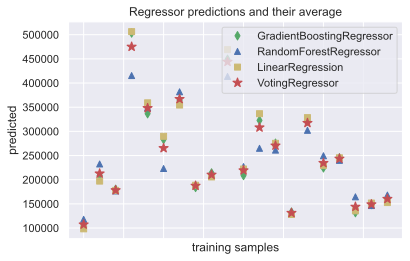

In [21]:
plt.figure()
plt.plot(pred1, 'gd', label='GradientBoostingRegressor')
plt.plot(pred2, 'b^', label='RandomForestRegressor')
plt.plot(pred3, 'ys', label='LinearRegression')
plt.plot(pred4, 'r*', ms=10, label='VotingRegressor')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')

plt.show()

In [22]:
model.fit(X_train,y_train)

0:	learn: 87240.0338737	total: 3.96ms	remaining: 3.96s
1:	learn: 82416.8178573	total: 6ms	remaining: 3s
2:	learn: 78048.1735162	total: 9.52ms	remaining: 3.16s
3:	learn: 74388.4214404	total: 11.6ms	remaining: 2.88s
4:	learn: 71181.5293922	total: 13.5ms	remaining: 2.69s
5:	learn: 68321.6472092	total: 15.9ms	remaining: 2.64s
6:	learn: 65982.3121180	total: 18.5ms	remaining: 2.62s
7:	learn: 63770.6509276	total: 20.5ms	remaining: 2.54s
8:	learn: 61880.9434898	total: 22.4ms	remaining: 2.47s
9:	learn: 60123.2985819	total: 24.3ms	remaining: 2.41s
10:	learn: 58625.1688396	total: 26.3ms	remaining: 2.36s
11:	learn: 57420.8818077	total: 28.2ms	remaining: 2.32s
12:	learn: 56408.8544712	total: 30.4ms	remaining: 2.31s
13:	learn: 55575.9365890	total: 32.9ms	remaining: 2.32s
14:	learn: 54798.8788967	total: 35.1ms	remaining: 2.31s
15:	learn: 54045.9352487	total: 36.9ms	remaining: 2.27s
16:	learn: 53505.5137248	total: 38.9ms	remaining: 2.25s
17:	learn: 52834.7906356	total: 40.6ms	remaining: 2.22s
18:	lear

189:	learn: 37615.2547588	total: 472ms	remaining: 2.01s
190:	learn: 37579.1820253	total: 474ms	remaining: 2.01s
191:	learn: 37540.3892177	total: 477ms	remaining: 2.01s
192:	learn: 37505.3882296	total: 479ms	remaining: 2s
193:	learn: 37446.6366723	total: 481ms	remaining: 2s
194:	learn: 37402.1804272	total: 483ms	remaining: 1.99s
195:	learn: 37324.5334451	total: 485ms	remaining: 1.99s
196:	learn: 37306.6545724	total: 487ms	remaining: 1.98s
197:	learn: 37252.8523944	total: 489ms	remaining: 1.98s
198:	learn: 37210.6694380	total: 492ms	remaining: 1.98s
199:	learn: 37154.5724264	total: 495ms	remaining: 1.98s
200:	learn: 37107.6536273	total: 497ms	remaining: 1.97s
201:	learn: 37088.3609982	total: 499ms	remaining: 1.97s
202:	learn: 37039.2136634	total: 501ms	remaining: 1.97s
203:	learn: 37009.7348285	total: 503ms	remaining: 1.96s
204:	learn: 36995.1109071	total: 505ms	remaining: 1.96s
205:	learn: 36930.7805889	total: 507ms	remaining: 1.96s
206:	learn: 36878.8602969	total: 509ms	remaining: 1.95

352:	learn: 32475.3387369	total: 797ms	remaining: 1.46s
353:	learn: 32442.4947206	total: 798ms	remaining: 1.46s
354:	learn: 32417.4758231	total: 800ms	remaining: 1.45s
355:	learn: 32402.2720970	total: 802ms	remaining: 1.45s
356:	learn: 32382.9513514	total: 804ms	remaining: 1.45s
357:	learn: 32372.0406859	total: 805ms	remaining: 1.44s
358:	learn: 32354.2653393	total: 807ms	remaining: 1.44s
359:	learn: 32330.6227288	total: 809ms	remaining: 1.44s
360:	learn: 32316.2837002	total: 811ms	remaining: 1.44s
361:	learn: 32276.5668822	total: 813ms	remaining: 1.43s
362:	learn: 32258.2725007	total: 815ms	remaining: 1.43s
363:	learn: 32233.3460601	total: 816ms	remaining: 1.43s
364:	learn: 32198.8523390	total: 818ms	remaining: 1.42s
365:	learn: 32173.3155953	total: 820ms	remaining: 1.42s
366:	learn: 32154.1886918	total: 822ms	remaining: 1.42s
367:	learn: 32136.5388869	total: 824ms	remaining: 1.41s
368:	learn: 32122.6424328	total: 830ms	remaining: 1.42s
369:	learn: 32085.6722242	total: 842ms	remaining

581:	learn: 27775.9048139	total: 1.28s	remaining: 918ms
582:	learn: 27763.5058895	total: 1.28s	remaining: 916ms
583:	learn: 27750.2178821	total: 1.28s	remaining: 913ms
584:	learn: 27730.0436311	total: 1.28s	remaining: 911ms
585:	learn: 27714.4769548	total: 1.28s	remaining: 908ms
586:	learn: 27689.6037891	total: 1.29s	remaining: 906ms
587:	learn: 27674.9758475	total: 1.29s	remaining: 903ms
588:	learn: 27662.6658612	total: 1.29s	remaining: 901ms
589:	learn: 27642.9617020	total: 1.29s	remaining: 899ms
590:	learn: 27628.8698122	total: 1.29s	remaining: 896ms
591:	learn: 27617.8223564	total: 1.3s	remaining: 894ms
592:	learn: 27613.3740982	total: 1.3s	remaining: 892ms
593:	learn: 27598.0388054	total: 1.3s	remaining: 889ms
594:	learn: 27570.0492208	total: 1.3s	remaining: 887ms
595:	learn: 27558.1850504	total: 1.3s	remaining: 884ms
596:	learn: 27537.8454320	total: 1.3s	remaining: 882ms
597:	learn: 27520.1495612	total: 1.31s	remaining: 879ms
598:	learn: 27505.4340120	total: 1.31s	remaining: 876m

744:	learn: 25271.5436552	total: 1.58s	remaining: 541ms
745:	learn: 25247.7948279	total: 1.58s	remaining: 539ms
746:	learn: 25233.1293430	total: 1.58s	remaining: 536ms
747:	learn: 25209.7390142	total: 1.58s	remaining: 534ms
748:	learn: 25201.4996248	total: 1.59s	remaining: 532ms
749:	learn: 25193.0564069	total: 1.59s	remaining: 530ms
750:	learn: 25182.3455715	total: 1.59s	remaining: 528ms
751:	learn: 25173.2107245	total: 1.59s	remaining: 526ms
752:	learn: 25161.0138904	total: 1.59s	remaining: 523ms
753:	learn: 25140.6473800	total: 1.6s	remaining: 521ms
754:	learn: 25134.6757573	total: 1.6s	remaining: 519ms
755:	learn: 25119.2243853	total: 1.6s	remaining: 517ms
756:	learn: 25103.3395526	total: 1.6s	remaining: 515ms
757:	learn: 25095.8140170	total: 1.61s	remaining: 513ms
758:	learn: 25083.7190719	total: 1.61s	remaining: 511ms
759:	learn: 25076.6993483	total: 1.61s	remaining: 508ms
760:	learn: 25061.4025268	total: 1.61s	remaining: 506ms
761:	learn: 25041.3863649	total: 1.61s	remaining: 50

895:	learn: 23586.8987285	total: 1.9s	remaining: 221ms
896:	learn: 23573.6528257	total: 1.9s	remaining: 219ms
897:	learn: 23559.3780304	total: 1.91s	remaining: 216ms
898:	learn: 23545.1064813	total: 1.91s	remaining: 214ms
899:	learn: 23533.3925309	total: 1.91s	remaining: 212ms
900:	learn: 23513.8199355	total: 1.91s	remaining: 210ms
901:	learn: 23493.6191094	total: 1.91s	remaining: 208ms
902:	learn: 23486.1025927	total: 1.92s	remaining: 206ms
903:	learn: 23456.5152109	total: 1.92s	remaining: 204ms
904:	learn: 23448.5234022	total: 1.92s	remaining: 202ms
905:	learn: 23435.5198644	total: 1.92s	remaining: 199ms
906:	learn: 23425.2216748	total: 1.92s	remaining: 197ms
907:	learn: 23397.8167178	total: 1.93s	remaining: 195ms
908:	learn: 23381.2722926	total: 1.93s	remaining: 193ms
909:	learn: 23363.4505366	total: 1.93s	remaining: 191ms
910:	learn: 23354.5318254	total: 1.93s	remaining: 189ms
911:	learn: 23346.3196059	total: 1.93s	remaining: 187ms
912:	learn: 23335.8919836	total: 1.93s	remaining: 

VotingRegressor(estimators=[('model_1',
                             GradientBoostingRegressor(max_depth=5,
                                                       n_estimators=400,
                                                       random_state=42)),
                            ('model_2',
                             RandomForestRegressor(max_depth=5, max_features=10,
                                                   n_estimators=1442,
                                                   random_state=42)),
                            ('model_3',
                             <catboost.core.CatBoostRegressor object at 0x000001D2D4D25700>)])

In [23]:
y_test_pred = model.predict(X_valid)

В задачах такого рода приятно ориентироваться на R2(Грубо говоря, он показывает % изменчивости, который описывает наша модель)

Но при сабмите на kaggle он может быть как значительно выше, так и ниже

In [24]:
r2_score(y_valid,y_test_pred)

0.7407170511272756

Обучим модель на всем датасете

In [25]:
model.fit(X,y)

0:	learn: 87185.2013797	total: 8.9ms	remaining: 8.89s
1:	learn: 82321.6035069	total: 12.2ms	remaining: 6.1s
2:	learn: 78142.8943166	total: 15.9ms	remaining: 5.28s
3:	learn: 74486.9104432	total: 18.9ms	remaining: 4.71s
4:	learn: 71280.2112859	total: 22.9ms	remaining: 4.56s
5:	learn: 68519.5638470	total: 26.5ms	remaining: 4.39s
6:	learn: 66217.6914401	total: 29.7ms	remaining: 4.21s
7:	learn: 64020.1702755	total: 32.6ms	remaining: 4.05s
8:	learn: 62122.5689027	total: 36.3ms	remaining: 3.99s
9:	learn: 60469.4365359	total: 39.2ms	remaining: 3.88s
10:	learn: 59070.5244789	total: 42ms	remaining: 3.77s
11:	learn: 57888.0213638	total: 44.9ms	remaining: 3.69s
12:	learn: 56858.2612275	total: 47.7ms	remaining: 3.62s
13:	learn: 55962.3968810	total: 52ms	remaining: 3.66s
14:	learn: 55166.8183741	total: 55.1ms	remaining: 3.62s
15:	learn: 54478.2992353	total: 58.3ms	remaining: 3.59s
16:	learn: 53955.1148144	total: 63.8ms	remaining: 3.69s
17:	learn: 53351.5383301	total: 67.2ms	remaining: 3.67s
18:	lear

197:	learn: 38640.7203762	total: 652ms	remaining: 2.64s
198:	learn: 38611.1380448	total: 655ms	remaining: 2.64s
199:	learn: 38570.6769092	total: 659ms	remaining: 2.63s
200:	learn: 38532.0863027	total: 662ms	remaining: 2.63s
201:	learn: 38506.9912760	total: 664ms	remaining: 2.62s
202:	learn: 38470.7465291	total: 667ms	remaining: 2.62s
203:	learn: 38451.7302611	total: 670ms	remaining: 2.61s
204:	learn: 38394.4887578	total: 673ms	remaining: 2.61s
205:	learn: 38351.2710056	total: 676ms	remaining: 2.6s
206:	learn: 38320.8427644	total: 678ms	remaining: 2.6s
207:	learn: 38271.6856415	total: 682ms	remaining: 2.6s
208:	learn: 38238.5199803	total: 685ms	remaining: 2.59s
209:	learn: 38204.0185831	total: 689ms	remaining: 2.59s
210:	learn: 38176.8165351	total: 692ms	remaining: 2.59s
211:	learn: 38153.8596599	total: 694ms	remaining: 2.58s
212:	learn: 38115.5676943	total: 697ms	remaining: 2.57s
213:	learn: 38087.8034544	total: 699ms	remaining: 2.57s
214:	learn: 38041.2223939	total: 702ms	remaining: 2

352:	learn: 34376.1355339	total: 1.14s	remaining: 2.09s
353:	learn: 34367.2441199	total: 1.14s	remaining: 2.08s
354:	learn: 34323.6857092	total: 1.14s	remaining: 2.08s
355:	learn: 34310.5619011	total: 1.15s	remaining: 2.08s
356:	learn: 34285.2575412	total: 1.15s	remaining: 2.07s
357:	learn: 34269.9437558	total: 1.15s	remaining: 2.07s
358:	learn: 34257.2368986	total: 1.16s	remaining: 2.06s
359:	learn: 34247.4646969	total: 1.16s	remaining: 2.06s
360:	learn: 34213.4277426	total: 1.16s	remaining: 2.06s
361:	learn: 34194.7101518	total: 1.17s	remaining: 2.06s
362:	learn: 34168.1502154	total: 1.17s	remaining: 2.05s
363:	learn: 34146.2478176	total: 1.17s	remaining: 2.05s
364:	learn: 34116.9306687	total: 1.18s	remaining: 2.04s
365:	learn: 34095.5147827	total: 1.18s	remaining: 2.04s
366:	learn: 34083.4165171	total: 1.18s	remaining: 2.04s
367:	learn: 34065.6137547	total: 1.18s	remaining: 2.03s
368:	learn: 34054.2170065	total: 1.19s	remaining: 2.03s
369:	learn: 34047.4019664	total: 1.19s	remaining

503:	learn: 31489.8189620	total: 1.62s	remaining: 1.6s
504:	learn: 31478.4859122	total: 1.63s	remaining: 1.59s
505:	learn: 31473.7823566	total: 1.63s	remaining: 1.59s
506:	learn: 31449.8596970	total: 1.63s	remaining: 1.59s
507:	learn: 31442.1058849	total: 1.64s	remaining: 1.59s
508:	learn: 31426.0864455	total: 1.64s	remaining: 1.58s
509:	learn: 31414.3050011	total: 1.65s	remaining: 1.58s
510:	learn: 31396.4727057	total: 1.65s	remaining: 1.58s
511:	learn: 31383.9020936	total: 1.65s	remaining: 1.57s
512:	learn: 31364.0354018	total: 1.65s	remaining: 1.57s
513:	learn: 31347.5558599	total: 1.66s	remaining: 1.57s
514:	learn: 31331.0885051	total: 1.66s	remaining: 1.56s
515:	learn: 31312.0139459	total: 1.66s	remaining: 1.56s
516:	learn: 31291.0104728	total: 1.67s	remaining: 1.55s
517:	learn: 31277.1090491	total: 1.67s	remaining: 1.55s
518:	learn: 31261.3460157	total: 1.67s	remaining: 1.55s
519:	learn: 31253.3283071	total: 1.67s	remaining: 1.54s
520:	learn: 31230.7869203	total: 1.68s	remaining:

661:	learn: 29161.1883672	total: 2.11s	remaining: 1.08s
662:	learn: 29155.0806411	total: 2.11s	remaining: 1.07s
663:	learn: 29132.5864758	total: 2.12s	remaining: 1.07s
664:	learn: 29115.3283553	total: 2.12s	remaining: 1.07s
665:	learn: 29106.6307346	total: 2.12s	remaining: 1.06s
666:	learn: 29088.7161629	total: 2.12s	remaining: 1.06s
667:	learn: 29079.2236232	total: 2.13s	remaining: 1.06s
668:	learn: 29072.4381884	total: 2.13s	remaining: 1.05s
669:	learn: 29061.5587681	total: 2.13s	remaining: 1.05s
670:	learn: 29040.5738016	total: 2.14s	remaining: 1.05s
671:	learn: 29026.9458710	total: 2.14s	remaining: 1.04s
672:	learn: 29013.8379375	total: 2.14s	remaining: 1.04s
673:	learn: 29004.9945584	total: 2.14s	remaining: 1.04s
674:	learn: 28994.0544497	total: 2.15s	remaining: 1.03s
675:	learn: 28978.2127595	total: 2.15s	remaining: 1.03s
676:	learn: 28964.7561970	total: 2.15s	remaining: 1.03s
677:	learn: 28944.8446194	total: 2.15s	remaining: 1.02s
678:	learn: 28928.5741357	total: 2.16s	remaining

808:	learn: 27446.4050943	total: 2.6s	remaining: 615ms
809:	learn: 27423.4003316	total: 2.61s	remaining: 611ms
810:	learn: 27410.7194447	total: 2.61s	remaining: 609ms
811:	learn: 27405.1882164	total: 2.61s	remaining: 605ms
812:	learn: 27396.3844636	total: 2.62s	remaining: 602ms
813:	learn: 27388.5258038	total: 2.62s	remaining: 599ms
814:	learn: 27379.1596936	total: 2.63s	remaining: 596ms
815:	learn: 27372.6840046	total: 2.63s	remaining: 593ms
816:	learn: 27366.4509257	total: 2.63s	remaining: 589ms
817:	learn: 27355.5150207	total: 2.63s	remaining: 586ms
818:	learn: 27346.9846913	total: 2.64s	remaining: 583ms
819:	learn: 27337.4574546	total: 2.64s	remaining: 580ms
820:	learn: 27319.2407952	total: 2.64s	remaining: 577ms
821:	learn: 27308.9819136	total: 2.65s	remaining: 573ms
822:	learn: 27294.8265987	total: 2.65s	remaining: 570ms
823:	learn: 27281.6597192	total: 2.65s	remaining: 567ms
824:	learn: 27268.1576990	total: 2.66s	remaining: 564ms
825:	learn: 27260.9480852	total: 2.66s	remaining:

955:	learn: 25963.5388785	total: 3.09s	remaining: 142ms
956:	learn: 25954.9865998	total: 3.09s	remaining: 139ms
957:	learn: 25947.7042201	total: 3.09s	remaining: 136ms
958:	learn: 25942.6284278	total: 3.1s	remaining: 132ms
959:	learn: 25938.9875225	total: 3.1s	remaining: 129ms
960:	learn: 25930.0224393	total: 3.1s	remaining: 126ms
961:	learn: 25923.7577712	total: 3.11s	remaining: 123ms
962:	learn: 25905.3121560	total: 3.11s	remaining: 120ms
963:	learn: 25900.9563319	total: 3.11s	remaining: 116ms
964:	learn: 25893.9442642	total: 3.12s	remaining: 113ms
965:	learn: 25885.5322833	total: 3.12s	remaining: 110ms
966:	learn: 25868.7210908	total: 3.12s	remaining: 107ms
967:	learn: 25857.3761982	total: 3.13s	remaining: 103ms
968:	learn: 25851.7794835	total: 3.13s	remaining: 100ms
969:	learn: 25846.7498888	total: 3.13s	remaining: 96.9ms
970:	learn: 25837.5401888	total: 3.13s	remaining: 93.6ms
971:	learn: 25829.0306022	total: 3.14s	remaining: 90.4ms
972:	learn: 25821.0158491	total: 3.14s	remaining

VotingRegressor(estimators=[('model_1',
                             GradientBoostingRegressor(max_depth=5,
                                                       n_estimators=400,
                                                       random_state=42)),
                            ('model_2',
                             RandomForestRegressor(max_depth=5, max_features=10,
                                                   n_estimators=1442,
                                                   random_state=42)),
                            ('model_3',
                             <catboost.core.CatBoostRegressor object at 0x000001D2D4D25700>)])

In [26]:
y_pred = model.predict(X_test)

In [27]:
test_wId['Price'] = y_pred
test_wId[['Id','Price']].to_csv('voting_predictions.csv', index = False)